In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
from PIL import Image
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.applications import VGG19, ResNet50V2, ResNet101V2, InceptionResNetV2, NASNetLarge, InceptionV3

### Loading in presetup files downloaded from https://ai.stanford.edu/~jkrause/cars/car_dataset.html

In [2]:
meta = scipy.io.loadmat('devkit/cars_meta.mat')
train = scipy.io.loadmat('devkit/cars_train_annos.mat')
test = scipy.io.loadmat('devkit/cars_test_annos_withlabels.mat')

In [3]:
classes = pd.DataFrame(meta['class_names'][0], columns=['title'])

classes['title']
classes_list = []
for value in classes['title']:
    value = value[0]
    classes_list.append(value)
    
classes['title'] = classes_list

In [4]:
classes[classes['title'].str.contains('Honda')]

,title
125,Honda Odyssey Minivan 2012
126,Honda Odyssey Minivan 2007
127,Honda Accord Coupe 2012
128,Honda Accord Sedan 2012


### Creating a function to get the image bounds, labels, and file names for both training and testing sets

In [5]:
def get_bounds_and_labels(dataset):
    dataset_file_name_list = []
    dataset_image_bounds = []
    dataset_label_name_list = []

    for i in range(dataset['annotations'].shape[1]):
        dataset_file_name_list.append(dataset['annotations'][:,i][0][5][0])
        dataset_label_name_list.append(dataset['annotations'][:,i][0][4][0][0]) 
        
        bounds_list = []
        for j in range(4):
            bounds_list.append(dataset['annotations'][:,i][0][j][0][0])
        dataset_image_bounds.append(bounds_list)
        #returns 3 variables to be unpacked 
    return dataset_file_name_list, dataset_label_name_list, dataset_image_bounds

### Running function on both training and testing data 

In [6]:
test_files, test_labels, test_bounds = get_bounds_and_labels(test)
train_files, train_labels, train_bounds = get_bounds_and_labels(train)

### Displaying partial output for training set variables

In [7]:
train_files[:5]

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']

In [8]:
train_labels[:5]

[14, 3, 91, 134, 106]

In [9]:
train_bounds[:5]

[[39, 116, 569, 375],
 [36, 116, 868, 587],
 [85, 109, 601, 381],
 [621, 393, 1484, 1096],
 [14, 36, 133, 99]]

### Displaying partial output for testing set variables

In [10]:
test_files[:5]

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']

In [11]:
test_labels[:5]

[181, 103, 145, 187, 185]

In [12]:
test_bounds[:5]

[[30, 52, 246, 147],
 [100, 19, 576, 203],
 [51, 105, 968, 659],
 [67, 84, 581, 407],
 [140, 151, 593, 339]]

### Creating function to set up dataframe for Image Data Generator

In [13]:
def create_file_dataframe():
    
    #creating list of file names from directory
    train_list_files = []
    for file in os.listdir('cars_train/'):
        train_list_files.append(file)
    
    #creating dataframe of file names
    df = pd.DataFrame(train_list_files, columns=['files'])
    
    new_labels = train_labels + test_labels
    #adding both training and testing data into one dataset then splitting later in the image data generator 
    df['label'] = new_labels
    df['label'] = df['label'].apply(lambda x: str(x).split(' '))
    
    return df

In [14]:
df = create_file_dataframe()
df

,files,label
0,00001.jpg,[14]
1,00002.jpg,[3]
2,00003.jpg,[91]
3,00004.jpg,[134]
4,00005.jpg,[106]
...,...,...
16180,test_08037.jpg,[63]
16181,test_08038.jpg,[16]
16182,test_08039.jpg,[17]
16183,test_08040.jpg,[38]


### Using TensorFlow's Image Data Generator to create matrices interpretable by the neural network

In [15]:
train_data_generator = ImageDataGenerator(rescale=1./255., validation_split=.1)
test_data_generator = ImageDataGenerator(rescale=1./255.)

In [16]:
training = train_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='cars_train/',
    x_col='files',
    y_col='label',
    subset="training",
    seed=42,
    shuffle=True,
    rotation_range=180,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    target_size=(150, 150),
    batch_size=64,
    class_mode="categorical")


validation = train_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='cars_train/',
    x_col='files',
    y_col='label',
    subset="validation",
    seed=42,
    shuffle=True,
    target_size=(150, 150),
    batch_size=64,
    class_mode="categorical")

Found 14567 validated image filenames belonging to 196 classes.
Found 1618 validated image filenames belonging to 196 classes.


### Importing EfficientNetB2 Model and setting a portion of the layers to trainable

In [17]:
pre_trained = efn.EfficientNetB2(weights='imagenet', include_top=False, 
                       input_shape=(150, 150, 3))

In [18]:
len(pre_trained.layers)

332

In [19]:
for layer in pre_trained.layers[:50]:
    layer.trainable = False
    
for layer in pre_trained.layers[50:]:
    layer.trainable = True

### Creating the model topology, optimizer, and compiling the model

In [20]:
model = Sequential()

model.add(pre_trained)

model.add(Dropout(.5))

model.add(Conv2D(filters=1280,           
                     kernel_size=(3, 3),
                     activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(196, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, metrics=['accuracy'])

### Displaying model layer summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 5, 5, 1408)        7768562   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 1408)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 1280)        16221440  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

### Fitting the model, validating using validation split created above

In [22]:
history = model.fit(training, validation_data=validation, epochs=50, verbose=1, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 228 steps, validate for 26 steps
Epoch 1/50
228/228 [==============================] - 94s 413ms/step - loss: 4.8350 - accuracy: 0.0357 - val_loss: 5.0434 - val_accuracy: 0.0624
Epoch 2/50
228/228 [==============================] - 73s 320ms/step - loss: 2.8473 - accuracy: 0.2596 - val_loss: 2.4738 - val_accuracy: 0.3517
Epoch 3/50
228/228 [==============================] - 73s 321ms/step - loss: 1.5744 - accuracy: 0.5297 - val_loss: 1.5352 - val_accuracy: 0.5593
Epoch 4/50
228/228 [==============================] - 73s 320ms/step - loss: 0.9858 - accuracy: 0.6921 - val_loss: 1.2113 - val_accuracy: 0.6557
Epoch 5/50
228/228 [==============================] - 73s 321ms/step - loss: 0.7076 - accuracy: 0.7741 - val_loss: 1.4107 - val_accuracy: 0.6378
Epoch 6/50
228/228 [==============================] - 73s 321ms/step - loss: 0.5554 - accuracy: 0.8211 - val_loss: 1.0313 - val_accuracy: 0.7262
Epoch 7/50
228/228 [=================

### Plotting accuracy over number of epochs

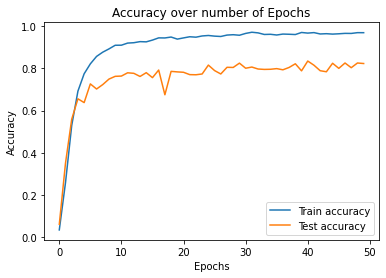

In [23]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over number of Epochs')
plt.legend();

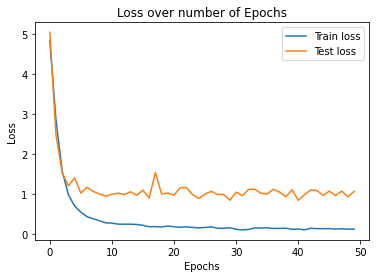

In [24]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of Epochs')
plt.legend();